### This notebook primarily serves as an exploratory analysis of our insider trade data set, 
which contains all non-derivative insider purchases made between June 2021 and October 2022. (According to [this post](http://epchan.blogspot.com/2017/07/building-insider-trading-database-and.html), derivative purchases represent a much more uncertain 'signal' with regards to the insider's intentions.)

In this notebook, we
- load, clean, and format the data from a CSV,
- explore the relationship between insider trade occurrence and ticker price change soon thereafter,
- explore the relationship between volume volatility prior to a trade and eventual price change, 
- visualize the distribution of outputs, and
- visualize some examples of ticker data with insider trades overlaid.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from my_functions import *

pd.options.mode.chained_assignment = None
plt.style.use('fivethirtyeight')

In [92]:
# start and end dates for our data
START_DATE = '2021-06-01'
END_DATE = '2022-11-04'

In [172]:
insiderDat, historicDat = my_cleaning.cleanAndFormatDF(
    '../data/sec4_June2021ToOct2022', 
    '../data/insiderDat_June2021ToOct2022_clean', 
    '../data/historicDat', 
    startDate= START_DATE, 
    endDate=END_DATE
)

There are 2883 unique tickers.

Example ticker data for AVNI:
              Open    High     Low   Close  Adj Close  Volume
Date                                                         
2021-06-01  0.4499  0.4499  0.4499  0.4499     0.4499       0
2021-06-02  0.4499  0.4499  0.4499  0.4499     0.4499       0
2021-06-03  0.4499  0.4499  0.4499  0.4499     0.4499       0
2021-06-04  0.4499  0.4499  0.4499  0.4499     0.4499       0
2021-06-07  0.4499  0.4499  0.4499  0.4499     0.4499    1000
...            ...     ...     ...     ...        ...     ...
2022-10-21  0.2750  0.2750  0.2750  0.2750     0.2750       0
2022-10-24  0.2750  0.2750  0.2750  0.2750     0.2750       0
2022-10-25  0.2750  0.2750  0.2750  0.2750     0.2750       0
2022-10-26  0.2700  0.4000  0.2700  0.4000     0.4000   13966
2022-10-27  0.5100  0.5100  0.5100  0.5100     0.5100    1000

[357 rows x 6 columns]

There are 415 tickers that no longer exist or were listed on an exchange after 2021-06-01 and are being rem

In [173]:
insiderDat

,FilingDate,TradeDate,Ticker,CompanyName,InsiderName,Title,TradeType,Price,Qty,Owned,DeltaOwn,Value
0,2021-06-01,2021-05-27,SFT,"Shift Technologies, Inc.",Russell Tobias,See Remarks,P - Purchase,7.08,10000.0,3063781.0,0.00,70800.0
1,2021-06-01,2021-05-27,SFT,"Shift Technologies, Inc.",Arison George,See Remarks,P - Purchase,7.12,10008.0,3343988.0,0.00,71216.0
2,2021-06-01,2021-05-27,SFT,"Shift Technologies, Inc.",Shein Oded,CFO,P - Purchase,7.00,10000.0,10000.0,0.00,70000.0
3,2021-06-01,2021-06-01,CARE,"Carter Bankshares, Inc.",Van Dyke Litz H,CEO,P - Purchase,15.41,129.0,18557.0,0.01,1988.0
4,2021-06-01,2021-05-27,LIND,"Lindblad Expeditions Holdings, Inc.",Berle Dolf A,CEO,P - Purchase,17.45,36500.0,58452.0,1.66,636974.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15780,2022-10-21,2022-10-20,REPX,"Riley Exploration Permian, Inc.",Libin Alvin Gerald,10%,P - Purchase,26.80,9007.0,1983573.0,0.00,241388.0
15781,2022-10-21,2022-10-19,GIM,Templeton Global Income Fund,Franklin Resources Inc,Affiliate of Investment Adv.,P - Purchase,4.07,128142.0,9462233.0,0.01,522029.0
15782,2022-10-21,2022-10-20,VOXX,Voxx International Corp,Kahli Beat,"Dir, 10%",P - Purchase,7.52,25000.0,5850000.0,0.00,188000.0
15783,2022-10-21,2022-10-20,RKT,"Rocket Companies, Inc.",Rizik Matthew,Dir,P - Purchase,6.39,6800.0,441702.0,0.02,43453.0


In [182]:
'''
Get historic SPY data for benchmarking.
'''
historicDat = my_retrieval.getHistoricDat(['SPY'], START_DATE, END_DATE, '../data/historicDat', historicDat=historicDat)

1 tickers to download.
[*********************100%***********************]  1 of 1 completed


In [112]:
'''
Get price percentage differences after 1 day, 3 days, 1 week, and 1 month.
'''
insiderDat_trunc = insiderDat[insiderDat.FilingDate < max(insiderDat.FilingDate)-dt.timedelta(days=30)]
EODayPrice = my_retrieval.returnPriceDiff(insiderDat_trunc, historicDat, delta=1, priceTime='Close')
EOWeekPrice = my_retrieval.returnPriceDiff(insiderDat_trunc, historicDat, delta=3, priceTime='Close')
EOMonthPrice = my_retrieval.returnPriceDiff(insiderDat_trunc, historicDat, delta=7, priceTime='Close')
EO3MonthPrice = my_retrieval.returnPriceDiff(insiderDat_trunc, historicDat, delta=30, priceTime='Close')

In [113]:
EO_Prices = {'1day': EODayPrice, '3day': EOWeekPrice, '1week': EOMonthPrice, '1month': EO3MonthPrice}

### Here we visualize the distribution of changes in price after insider trades.

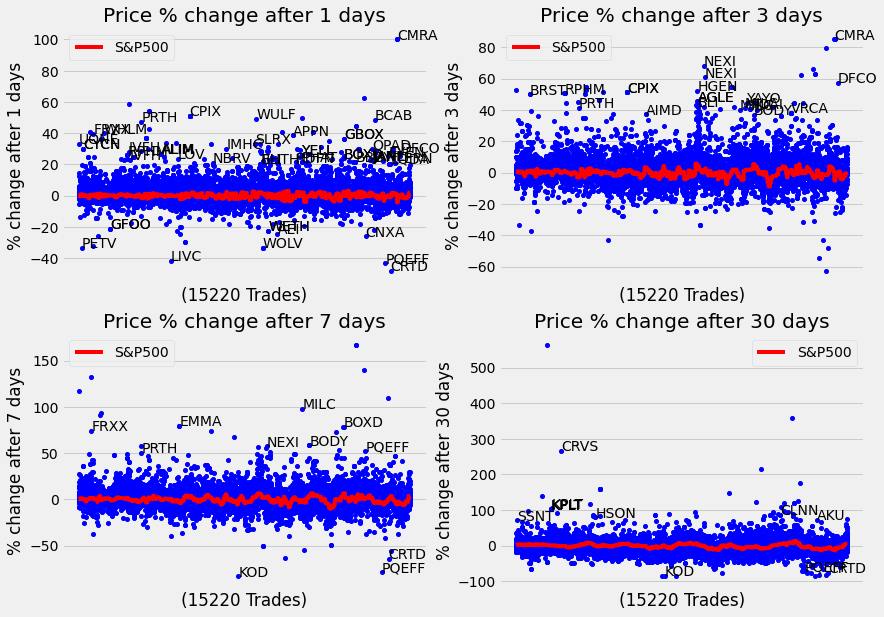

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))

my_plots.plotPriceDifference(EO_Prices['1day'], delta=1, labelThresh=20, ax=axs[0,0])
my_plots.plotPriceDifference(EO_Prices['3day'], delta=3, labelThresh=35, ax=axs[0,1])
my_plots.plotPriceDifference(EO_Prices['1week'], delta=7, labelThresh=50, ax=axs[1,0])
my_plots.plotPriceDifference(EO_Prices['1month'], delta=30, labelThresh=70, ax=axs[1,1])

plt.show()

#### Notice that there are many outliers above and below the "band" in each plot.

Also notice that far more tickers have undergone significant losses after 30 days (in comparison to shorter time spans). This suggests the valuation effects of insider purchases tend to be shorter-term than 30 days (either that, or much longer).

Let's look into the price trends of only those tickers that experienced qualitatively-outlying increases -- after all, insider buying is a bullish signal, and we want to learn to identify the strongest signals.

In [126]:
'''
In this cell, we gather together the price futures of trades that experienced an outlying price jump 
within a given period after an insider trade.
'''

daysToLookForward = 30  # plot prices over this many days

thresh = 20  # Threshold percentage price jump

outlierClosings = {key: np.full((1,daysToLookForward), np.nan) for key in EO_Prices.keys()}

for tradeNum, trade in insiderDat_trunc.iterrows():
    tick = trade['Ticker']
    tickDat = historicDat[tick]
    tradeName = tick + str(tradeNum)
    fileDate = str(trade['FilingDate'])

    '''
    If the trade's ticker changes by a sufficient amount, store its daily closing for the next 
    'days2lookForward' days.
    '''   
    for key in EO_Prices.keys():
        priceChange = EO_Prices[key][tradeName][0]
        
        if priceChange < thresh: continue
            
        newRow = np.full((1,daysToLookForward), np.nan)
        startingPrice, _ = my_retrieval.returnDataOnDate(tick, tickDat, fileDate, delta=0)
        for d in range(daysToLookForward):
            closingPrice, _ = my_retrieval.returnDataOnDate(tick, tickDat, fileDate, delta=d)
            newRow[0,d] = 100*(closingPrice-startingPrice)/startingPrice

        outlierClosings[key] = np.append(outlierClosings[key], newRow, axis=0)

### Here, we focus on price trends for only those tickers that achieve outlying results.

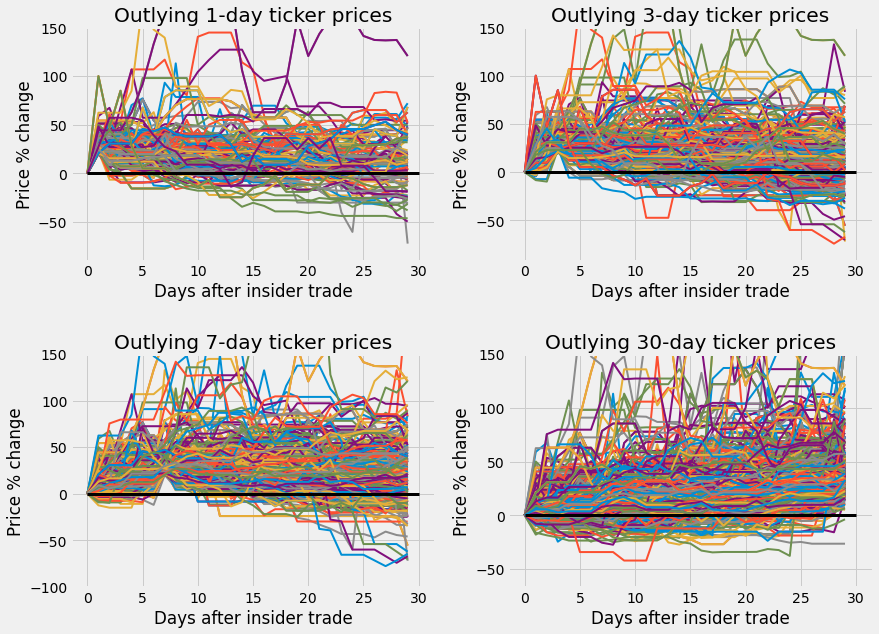

In [128]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))

my_plots.plotOutlyingPriceDifference(outlierClosings['1day'], daysToLookForward, delta=1, ax=axs[0,0])
my_plots.plotOutlyingPriceDifference(outlierClosings['3day'], daysToLookForward, delta=3, ax=axs[0,1])
my_plots.plotOutlyingPriceDifference(outlierClosings['1week'], daysToLookForward, delta=7, ax=axs[1,0])
my_plots.plotOutlyingPriceDifference(outlierClosings['1month'], daysToLookForward, delta=30, ax=axs[1,1])

plt.subplots_adjust(hspace=0.4)
plt.show()

At first glance, we seem to have a bunch of spaghetti.

However, if we look closer, we notice that it appears that many outlying upward price jumps occur within at most a few days of the filing date and then fall back down in the next month -- often to a loss, relative to the date of purchase. Yet, for prices that are outlying a month or more after the filing, these jumps seem to happen more gradually -- if anything, it seems like the valuation is *unreactive* to the insider trade for some time after filing in the 30-day plot.

We're living in a time where the market has been somewhat volatile. It's safer to make predictions based on perceived direct causality, i.e. "insider trade causes price to jump within a few days." (An algothm is also more likely to learn direct causality!) 

### Takeaway: We'll choose a small look-ahead window over which to engineer our model output (i.e. change in valuation).
Let's go with 5 days.

In [134]:
DAYS_TO_LOOK_FORWARD = 5
DAYS_TO_LOOK_BACK = 5  # for computing volume volatility and related insider buys
#WINDOW_LEN = 3  # number of days over which to compute best mean price increase across DAYS_TO_LOOK_FORWARD

Now we should explore a few other things of interest, namely
- the volume and price volatility over the previous few days, which we define by $\frac{\sigma}{\mu}$, and
- plot price with trade types overlaid.

In [181]:
'''
Compute the max price change for each ticker in the next DAYS_TO_LOOK_FORWARD and the recent volume volatility.
'''
startDate = min(insiderDat_trunc.FilingDate)
endDate = max(insiderDat_trunc.FilingDate)

volatilities = [0]*len(insiderDat_trunc.index)
priceChanges = [0]*len(insiderDat_trunc.index)
for tradeNum, trade in insiderDat_trunc.iterrows():
    tick = trade['Ticker']
    tickDat = historicDat[tick]
    fileDate = trade['FilingDate']
    
    # skip the first DAYS_TO_LOOK_BACK days to ensure there is data to look back at
    if (fileDate - dt.timedelta(days=DAYS_TO_LOOK_BACK)) < startDate:
        volatilities[tradeNum] = (np.nan, np.nan)
        priceChanges[tradeNum] = np.nan
        continue
    
    volatilities[tradeNum] = my_retrieval.returnVolatilities(
        tickDat, fileDate, 'Close', DAYS_TO_LOOK_BACK
    )
    
    priceChanges[tradeNum] = my_retrieval.returnBestPriceChange(
        tick, tickDat, fileDate, 'Close', DAYS_TO_LOOK_FORWARD
    )

### Here is the distribution of price changes, i.e. our model outputs:

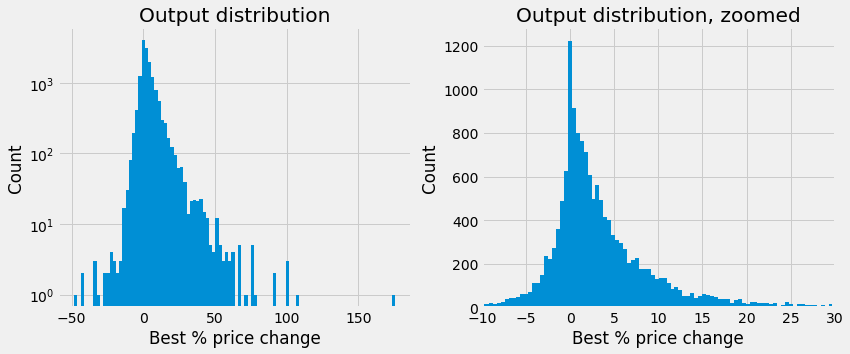

In [153]:
fig, axs = plt.subplots(1, 2, figsize=(2*6.2, 4.8))
axs[0].hist(priceChanges, bins=100)
axs[0].semilogy()
axs[0].set_xlabel('Best % price change')
axs[0].set_ylabel('Count')
axs[0].set_title('Output distribution')
axs[1].hist(priceChanges, bins=500)
axs[1].set_xlim(left=-10, right=30)
axs[1].set_xlabel('Best % price change')
axs[1].set_ylabel('Count')
axs[1].set_title('Output distribution, zoomed')
plt.show()

We have a highly right-tailed distribution, and that outlier at 175 would particularly influence the training progress.

The natural "tails" seem to begin at -10% and end around 25%. Furthermore, because we're only interested in bullish signals, we interpret predicted losses and predicted zero return the same: either way, we won't purchase that stock!

### Thus, when performing feature creation, we will artificially cap our outputs in the interval [0, 25)%.

In doing this, we still represent major runs with the upper bound, and major losses with the lower bound.

That gives us the following distribution:

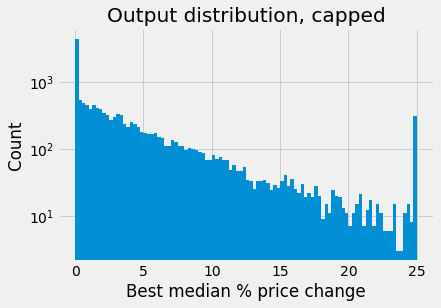

In [155]:
fig, ax = plt.subplots(1, 1)
ax.hist([min(max(val, 0), 25) for val in priceChanges], bins=100)
ax.semilogy()
ax.set_xlabel('Best median % price change')
ax.set_ylabel('Count')
ax.set_title('Output distribution, capped')
plt.show()

### We should also implement oversampling of targets that are underrepresented.

We'll create 3 bins: 0-1% (which has way too much representation), 1-10%, and >10%. In particular, this should provide us with more examples of semi-high to high gain.

Now, let's look at the impact of volatility.

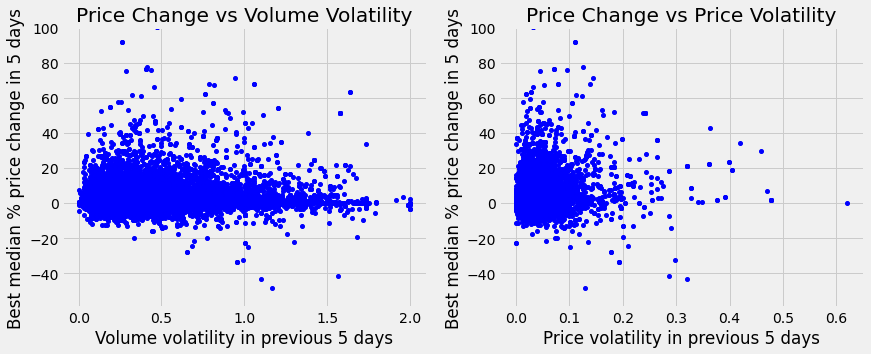

In [157]:
my_plots.plotVolatilityPriceScatter(volatilities, priceChanges, DAYS_TO_LOOK_FORWARD, DAYS_TO_LOOK_BACK)

I'm kind of surprised by this. I figured that a lot of gainers would have high volatility, but in fact, high volatility seems to loosely correlate with small price change.

However, after thinking about it for a bit, low volatility may give investors more faith in insiders' purchases.

#### Finally, let's look more closely at some example ticker histories and their associated trades.

In [158]:
insiderDat_trunc.Ticker.value_counts()

TPL     335
ED      157
FRAF    149
KFS     122
VOXX    119
       ... 
PSNL      1
HDSN      1
RGTI      1
OPCH      1
RLJ       1
Name: Ticker, Length: 2428, dtype: int64

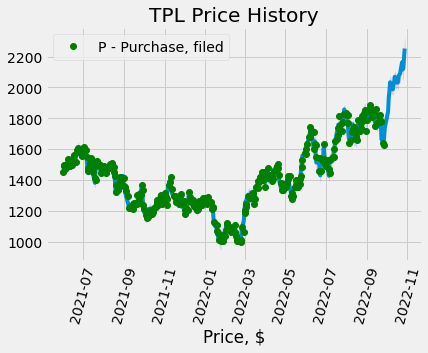

In [159]:
tick = 'TPL'
my_plots.plotPriceWithTrades(
    tick, historicDat[tick], insiderDat_trunc[insiderDat_trunc.Ticker == tick], START_DATE, END_DATE
)

TPL has the most trades in the given time period. Surely, many of these purchases are just routine transactions.

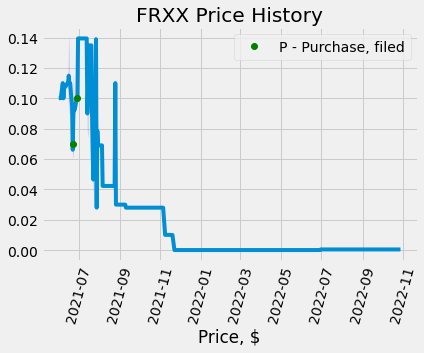

In [160]:
tick = 'FRXX'
my_plots.plotPriceWithTrades(
    tick, historicDat[tick], insiderDat[insiderDat.Ticker == tick], START_DATE, END_DATE
)

FRXX is an interesting one. There was literally no volume on many days.

Both filings occurred right before a price jump, likely as a pump-and-dump scheme for a failing company.

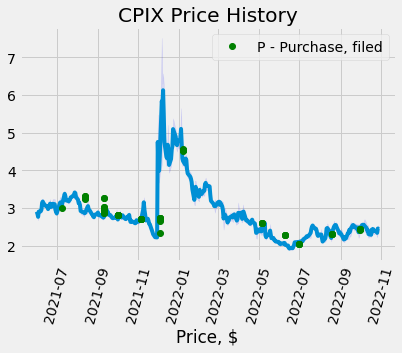

In [163]:
tick = 'CPIX'
my_plots.plotPriceWithTrades(
    tick, historicDat[tick], insiderDat[insiderDat.Ticker == tick], START_DATE, END_DATE
)

And here's CPIX. It looks like some purchases may have anticipated the huge run, and some afterwards may be trying to anticipate the next big run.